-------------------------------------------------------------

# Exercise 1.1

# Prepping data

In [1]:
# file imports
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.optimize import minimize as minimize
import time
import random
import itertools
import copy
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge

In [2]:
# splitting data in train test and val set
def data_split(data, val = True):
    
    X = np.array(data.iloc[:,:2])
    y = np.array(data.iloc[:, 2])
    
    # train-val split 100% -> 70% - 30%
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1) 
    
    if val == False:
        return X_train.T, X_val.T, y_train, y_val
    
    else:
    # val-test split 30% -> 15% - 15%
        X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, test_size=0.5, random_state=1)
        return X_train.T, X_test.T, X_val.T, y_train, y_test, y_val


data = pd.read_excel(r'C:\Users\RE-Giorgio\Downloads\dataPoints.xlsx')
random.seed(1696995)
X_train, X_test, X_val, y_train, y_test, y_val = data_split(data)

# Neural Network parent class

In [3]:
# common class for shallow neural newtworks with 1 output node
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.normal(0,1,(self.N, self.X.shape[0]))
        self.b = np.random.normal(0,1,(self.N,1))
        self.v = np.random.normal(0,1,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) +\
            self.rho*np.square(np.linalg.norm(params))
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return np.mean(np.square(self.predict(X, w, b, v) - y)) 

## MLP child class

In [92]:
# Mlp inherits the general charectiristics of a shallow nn 
class Mlp(ShallowNeuralNetwork):
    
    # activation function (hyperbolic tangent)
    def g(self, x):
        return (np.exp(2*self.sigma*x)-1)/(np.exp(2*self.sigma*x)+1)

    # forward propagation
    def predict(self, x, w, b, v):
        
        z = w @ x - b
        a = self.g(z)
        self.output = v @ a
        return self.output

    # derivative of activation function
    def g_der(self, x):
        return (4*self.sigma*np.exp(2*self.sigma*x))/np.square(np.exp(2*self.sigma*x)+1)
    
    def grad(self, params):
        
        w, b, v = self.separate(params)
        z = w @ self.X - b
        f_x = self.predict(self.X, w, b, v)
        
        dw = 2*self.rho*w + (1/self.X.shape[1]) * (((v.T @ (f_x-self.y)) * self.g_der(z)) @ X_train.T)
        db = 2*self.rho*b + ((v.T @ (f_x-self.y)) * self.g_der(z)) * -1
        db =(1/self.X.shape[1]) *  np.sum(db, axis = 1, keepdims = True)
        dv = 2*self.rho*v + (1/self.X.shape[1]) * (f_x-y_train) @ self.g(z).T
        

        return np.concatenate([array.reshape(-1) for array in [dw, db, dv]])
        
                          
    # optimization of the objective function
    def optimize(self):
        
        inits = np.concatenate([array.reshape(-1) for array in [self.w, self.b, self.v]])
        
        print("begin training...", "\n")
        start = time.time()
        result =  minimize(self.loss, x0 = inits, method = self.method, jac = self.grad)
        time_elapsed = time.time() - start
        print(result)
        print("finished training.")
        
        # optimal parameters
        self.w, self.b, self.v = self.separate(result.x)
        
        return result.nfev, result.njev, result.nit, result.fun, result.jac, time_elapsed

## first run

In [90]:
nn = Mlp(X_train, y_train, N = 100, sigma = 5, rho = 10e-5, method = "BFGS")
func_eval, grad_eval, iterations, opt_fun, jacobian, time_elapsed = nn.optimize()
print("Training Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))#0.0007

begin training... 

      fun: 0.0005566193863219355
 hess_inv: array([[ 1.99262514, -0.3304307 , -0.74490513, ...,  0.21588824,
        -0.70808576, -0.04529101],
       [-0.3304307 ,  1.14217612,  0.27047404, ..., -0.08639263,
         0.30902265, -0.02994361],
       [-0.74490513,  0.27047404,  1.66942512, ..., -0.15296154,
         0.50216505,  0.08532023],
       ...,
       [ 0.21588824, -0.08639263, -0.15296154, ...,  1.06476644,
        -0.3511197 ,  0.04238625],
       [-0.70808576,  0.30902265,  0.50216505, ..., -0.3511197 ,
         2.50167176, -0.24038689],
       [-0.04529101, -0.02994361,  0.08532023, ...,  0.04238625,
        -0.24038689,  1.29351184]])
      jac: array([ 4.99578961e-05,  7.76089855e-05, -1.30772039e-05,  2.72990878e-04,
       -2.35839184e-05, -5.72912470e-05, -2.16564826e-04,  2.23856897e-04,
       -1.08725046e-04, -1.30943516e-04, -2.47951803e-04,  2.12935394e-04,
       -8.83687501e-05, -1.07025444e-04, -5.68124388e-04, -7.93746229e-05,
        7.60

       -1.40445711e-01,  5.77685991e-03, -4.73695184e-01,  2.18249604e-01])
finished training.
[ 4.99578961e-05  7.76089855e-05 -1.30772039e-05  2.72990878e-04
 -2.35839184e-05 -5.72912470e-05 -2.16564826e-04  2.23856897e-04
 -1.08725046e-04 -1.30943516e-04 -2.47951803e-04  2.12935394e-04
 -8.83687501e-05 -1.07025444e-04 -5.68124388e-04 -7.93746229e-05
  7.60369003e-05  1.49526138e-04 -6.74636677e-04  3.50107077e-04
  7.26559789e-05 -1.01623721e-04 -1.85704498e-03  9.26563533e-04
  8.53536368e-05  1.56224749e-04  5.63061115e-04  3.31786419e-04
 -1.78596542e-04 -1.02768290e-04 -8.25544893e-05 -2.17333103e-04
  7.55397051e-05 -1.34644595e-04  1.43047677e-05  1.67936608e-04
  6.85309789e-05  1.87538578e-04  2.65466852e-04  7.44563233e-04
 -1.92829588e-03  3.28737892e-04 -4.07795224e-05  7.92312016e-05
 -7.13748570e-05  1.04362906e-04  3.21518293e-04  8.79187040e-05
  5.48853907e-04  1.30851886e-04 -1.92089053e-04  1.16021098e-04
  2.60122621e-04 -9.67889179e-05 -1.39894117e-04  5.32326955

In [91]:
np.linalg.norm(jacobian)

0.006779600232990822

In [16]:
def plot(nn):
    
    # creates 3d space
    fig = plt.figure()
    ax = Axes3D(fig)
    
    # grid of the support of the estimated function
    x1 = np.linspace(-1, 1, 200)
    x2 = np.linspace(-2, 2, 200)
    X1, X2 = np.meshgrid(x1, x2)
    
    # predictions on the given support
    Y = np.array([nn.predict(np.array([x1[i], x2[k]]).reshape(2,1),
                             nn.w, nn.b, nn.v) for i in range(200) for k in range(200)])
    Y = Y.ravel().reshape(200,200)
    
    # plotting
    ax.plot_surface(X1, X2, Y, rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()
    


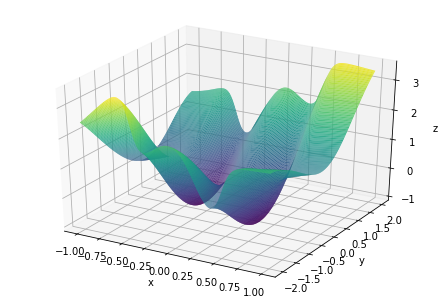

In [17]:
plot(nn)

In [ ]:
#
# Grid Search (takes ~2 hours) -------> (50, 5, 0.0001, 'CG') error on val of ~0.00022
#

"""
param_grid = {"N" : [10, 20, 50], "sigma" : [1, 2, 5], "rho" : [10e-4, 10e-5], "method" : ["BFGS", "CG"]}

results = []
combinations = list(itertools.product(*param_grid.values()))
for comb in tqdm_notebook(combinations):
    
    print("current combination :", comb)
    print("\n")
    nn = Mlp(X_train, y_train, N = comb[0], sigma = comb[1], rho = comb[2], method = comb[3])
    nn.optimize()
    results.append(nn.mse(X_val, y_val, nn.w, nn.b, nn.v))
"""

------------------------------------

# Exercise 2.1

the error reduces to: $\underset{w_0, b_0, v}{min} \frac{1}{2P} (\sum_{p=1}^P v_j \sum_{i=1}^nw_{ij}x + b_j)- y^p)^2 + \rho||\mathbf{\omega}||^2 = ||\mathbf{v}(\mathbf{W}\mathbf{X} + \mathbf{b}) - \mathbf{Y}||^2 + \rho||\mathbf{v}||^2$



In [18]:
X_train, X_test, y_train, y_test = data_split(data, val = False)

In [44]:
class ShallowNeuralNetwork:
    
    # defines the variables for a shallow nn with scalar output
    def __init__(self, X, y, N, sigma, rho, method = None):

        self.X = X
        self.y = y
        self.N = N
        self.w = np.random.uniform(-1,1,(self.N, self.X.shape[0]))
        self.b = np.random.uniform(-0.5,0.5,(self.N,1))
        self.v = np.random.uniform(-0.5,0.5,(1, self.N))
        self.output = np.zeros(y.shape[0])
        self.rho = rho
        self.sigma = sigma
        self.method = method

    # separates the previously concatenated arguments
    def separate(self, l):
        
        shapes = [(self.N, self.X.shape[0]), (self.N, 1), (1, self.N)]
        sliced = np.split(l, np.cumsum([shapes[i][0]*shapes[i][1] for i in range(3)]))
        w, b, v = [np.array(sliced[i]).reshape(shapes[i]) for i in range(3)]
        return w, b, v
    
    # objective function to minimize
    def loss(self,params):
        
        w, b, v = self.separate(params)
        return 0.5 * np.mean(np.square((self.predict(self.X, w, b, v) - self.y))) 
    
    # metric for train and test accuracy
    def mse(self, X, y, w, b, v):
        return 0.5*np.mean(np.square(self.predict(X, w, b, v) - y)) 

In [45]:
class Mlp_El(ShallowNeuralNetwork):

    # activation function (hyperbolic tangent)
    def g(self, x):
        return (1-np.exp(-2*x*self.sigma))/(1+np.exp(-2*x*self.sigma))
    
    def optimize(self):
        
        z = self.w @ self.X - self.b
        H = self.g(z)
        H = np.concatenate((H.T, np.sqrt(self.rho)*np.identity(self.N))).T
        y = np.concatenate((self.y, np.zeros(self.N)))

        self.v =  np.linalg.inv(H @ H.T) @ H @ y # equal to self.v = y @ np.linalg.pinv(H) (moore-penrose pseudo inverse)
        
            
    # forward propagation
    def predict(self, x, w, b, v):
        
        a = w @ x - b
        z = self.g(a)
        self.output = v @ z
        return self.output

In [57]:
# extreme  learning traning
print("begin training...", "\n")
start = time.time()

while nn.mse(X_test, y_test, nn.w, nn.b, nn.v) > 0.020 or nn.mse(X_train, y_train, nn.w, nn.b, nn.v) > 0.02:
    nn = Mlp_El(X_train, y_train, N = 50, sigma = 5, rho = 10e-5)
    nn.optimize()
    
time_elapsed = time.time() - start
print("finished training.")
        
print("Train Error :", nn.mse(X_train, y_train, nn.w, nn.b, nn.v))
print("Test Error :", nn.mse(X_test, y_test, nn.w, nn.b, nn.v))

Train Error : 0.015430365060784063
Test Error : 0.015458757228748324


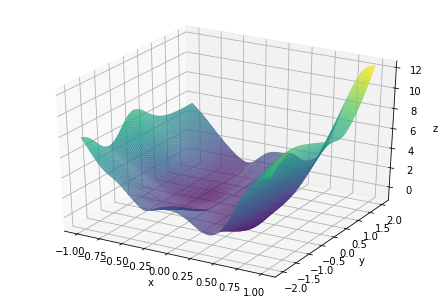

In [58]:
plot(nn)